# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from mpl_toolkits.mplot3d import Axes3D

from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [2]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

### Preprocessing Data
Function to preprocess the data. 

In [3]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

### Pivoting Frequency values to columns

In [4]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [5]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/processed/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(4)

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.366256,24.172872,A
1,100.0,-0.244170,37.846416,A
2,100.0,-1.831278,42.241484,A
3,100.0,1.220852,36.015138,A


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_26408\2752713674.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


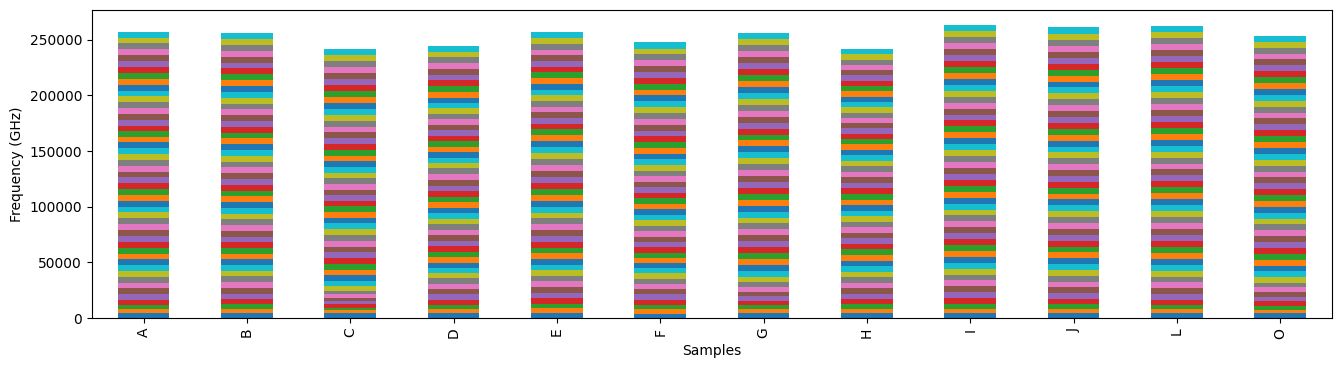

Mean value: 5073


C:\Users\Danim\AppData\Local\Temp\ipykernel_26408\2752713674.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


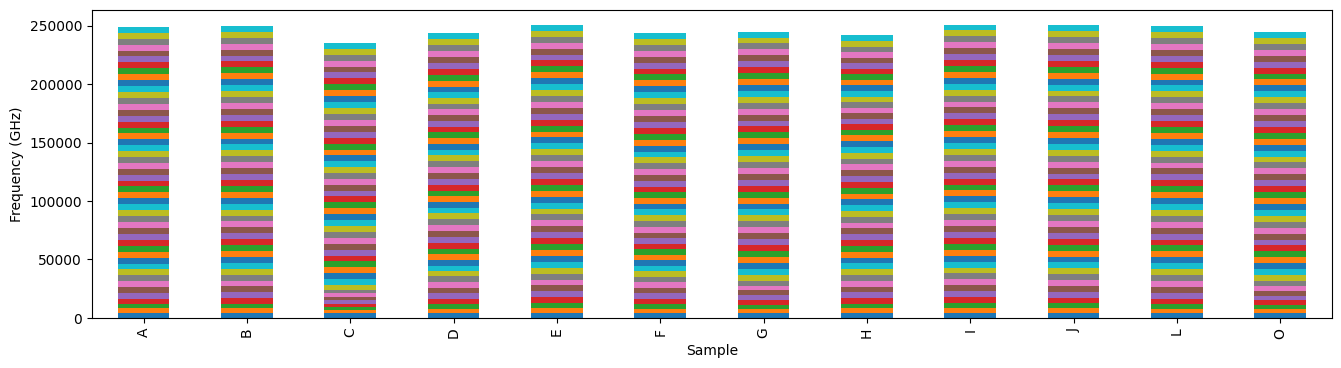

In [6]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
bx.get_legend().remove() #remove legend
plt.show()

# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
bx.get_legend().remove() #remove legend
plt.show()

### Data Feature Transformations Visualization

In [1]:
# Group by 'Sample' and 'Frequency (GHz)' and calculate the mean and standard deviation
mean_std_df = df_ori.groupby(['Sample', 'Frequency (GHz)']).agg(
    LG_mean=('LG (mV)', 'mean'),
    LG_std=('LG (mV)', 'std'),
    HG_mean=('HG (mV)', 'mean'),
    HG_std=('HG (mV)', 'std')
).reset_index()

print(mean_std_df)

# Substract the HG mean value of the previous frequency 
# Create a new DataFrame to store the differences
diff_df = mean_std_df.copy()

# Calculate the difference in HG and LGmean values between consecutive frequencies for each sample
diff_df['HG_mean_diff'] = diff_df.groupby('Sample')['HG_mean'].diff()
diff_df['LG_mean_diff'] = diff_df.groupby('Sample')['LG_mean'].diff()

# Rows where the difference could not be calculated are equal to 0
diff_df['HG_mean_diff'] = diff_df['HG_mean_diff'].fillna(0)
diff_df['LG_mean_diff'] = diff_df['LG_mean_diff'].fillna(0)

print(diff_df)


# Plot the difference in HG mean values for each sample
unique_samples = diff_df['Sample'].unique()

fig, axes = plt.subplots((len(unique_samples) + 3) // 4, 4, figsize=(20, 5 * ((len(unique_samples) + 3) // 4)), sharex=True)

for i, sample in enumerate(unique_samples):
    row, col = divmod(i, 4)
    sample_df = diff_df[diff_df['Sample'] == sample]
    sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[row, col], label=sample)
    axes[row, col].set_ylabel('HG Mean Difference')
    axes[row, col].legend(title='Sample')
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[row, col].grid(True, alpha=0.5)  # Add grid with transparency

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

axes[-1, 0].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


# Plot the difference in HG mean values for each group of samples starting with the same letter
unique_sample_groups = sorted(set(sample[0] for sample in unique_samples))

# Calculate the number of rows needed
n_rows = len(unique_sample_groups)

fig, axes = plt.subplots(n_rows, 1, figsize=(20, 5 * n_rows), sharex=True)

# Ensure axes is always a 1D array
if n_rows == 1:
    axes = np.array([axes])

for i, group in enumerate(unique_sample_groups):
    group_samples = [sample for sample in unique_samples if sample.startswith(group)]
    for sample in group_samples:
        sample_df = diff_df[diff_df['Sample'] == sample]
        sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[i], label=sample)
    axes[i].set_ylabel('HG Mean Difference')
    axes[i].legend(title='Sample')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[i].grid(True, alpha=0.5)  # Add grid with transparency

axes[-1].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


NameError: name 'df_ori' is not defined

### Sample a test set

In [7]:
df_train = df_balanced.copy()

test_percentage = 0.25

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()


,Frequency (GHz),LG (mV),HG (mV),Sample
2589936,580.0,-0.854596,16.115248,L
1286620,360.0,0.610426,622.512519,F
2827472,380.0,0.976682,374.679559,O
1340563,270.0,1.465023,-1.098752,F
1173165,470.0,0.854596,120.376033,E


### Distribution Plots

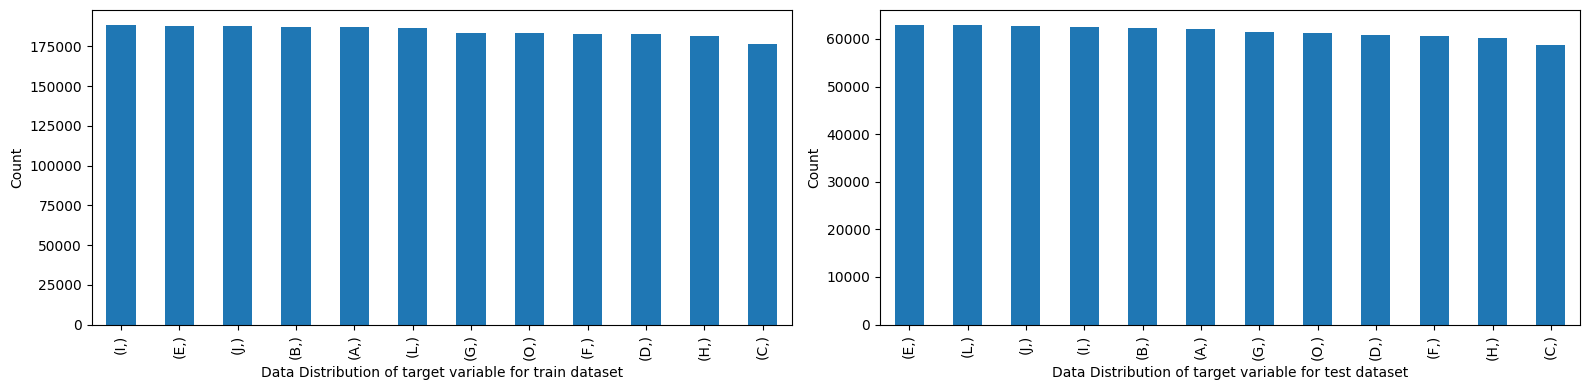

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

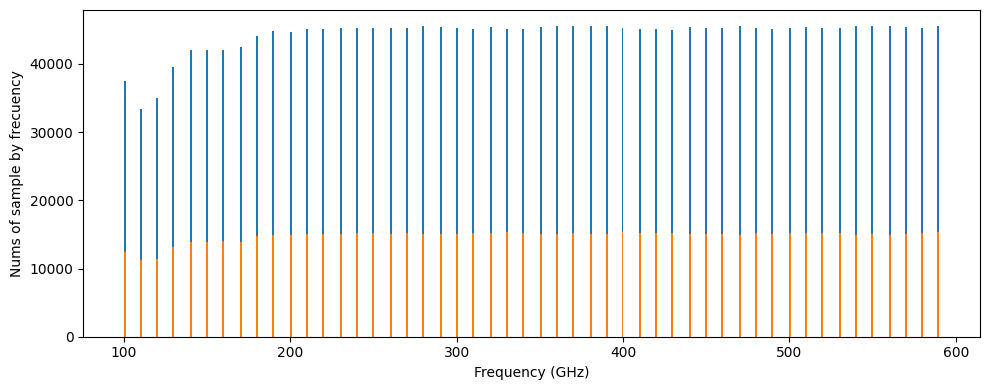

In [ ]:
train_ex = train_set.copy()

# train_ex.info()
# train_ex.describe()

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

### Data Windowing

In [41]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 4
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()


Data percentage: 0.1388888888888889%
Data percentage test: 0.41666666666666674%


In [ ]:
# Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/test_set.csv'

train_set_test.to_csv(output_path, sep = ';', index=False)
test_set_test.to_csv(output_path_test, sep = ';', index=False)

## Prepare Training Data
### Split data into X and y


In [9]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False, eliminate_LG=False, drop_sample=True):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    if eliminate_LG:
        # Eliminate LG columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'LG' in col])

    return X_, y_


### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting

In [10]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

### Train all Models

In [11]:
def train_models(X_train, y_train, seed):
    rf_model = random_forest_model(X_train, y_train, seed)
    nb_model = naive_bayes_model(X_train, y_train)
    lr_model = logistic_regression_model(X_train, y_train, seed)
    gb_model = gradient_boosting_model(X_train, y_train, seed)
    return rf_model, nb_model, lr_model, gb_model

def save_models(rf_model, nb_model, lr_model, gb_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')

In [12]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.7):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [13]:
# AIC Criteria
def aic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    aic = 2 * n_features + n * np.log((rss + epsilon) / n)
    return aic

# BIC Criteria (Also consider the number of samples)
def bic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    bic = np.log(n) * n_features + n * np.log((rss + epsilon) / n)
    return bic

In [14]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions, n_features, freqs, 
                      aic_scores, bic_scores, csv_path='comparison_results.csv', verbose=0):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'AIC': aic_scores,
        'BIC': bic_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models)
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AIC', 'BIC']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    if verbose >= 1:
        print(f"\nTest #{current_test} Results:")
        print(results_df)
        if verbose >= 2:
            print("\nAll Results:")
            print(updated_results)
        
    return updated_results

In [40]:
def evaluate_models(y_test, y_pred, verbose=0):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aic_scores = []
    bic_scores = []
    predictions_list = []

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_i, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_i, average='weighted', zero_division=0)

        # Calculate AIC and BIC
        y_test_num = le.transform(y_test)
        y_pred_num = le.transform(y_pred_i)
        n_features = len(y_pred_i)
        aic = aic_score(y_test_num, y_pred_num, n_features)
        bic = bic_score(y_test_num, y_pred_num, n_features)

        print(f"Model {i+1} - Accuracy: {accuracy}")
        print(f"Model {i+1} - Precision: {precision}")
        print(f"Model {i+1} - Recall: {recall}")
        print(f"Model {i+1} - F1: {f1}")
        print(f"Model {i+1} - AIC: {aic}")
        print(f"Model {i+1} - BIC: {bic}")


        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))

        if verbose >= 1:
            print(f"Model {i+1} - Predictions: {predictions}\n")
            if verbose >= 2:
                # Classification report
                print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')


        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aic_scores.append(aic)
        bic_scores.append(bic)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions_list

In [16]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


In [36]:
# Subset of specific Samples to use in the training
# labels = ['B', 'C', 'E', 'R']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']

# Subset of specific frequencies to use as input features, if freqs = [] then all frequencies are used
# freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 
340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]

# Count number of frequencies
print(f'freqs number: {len(freqs)}')

X_train, y_train = preprocess_data(train_set_test, labels, freqs, drop_sample=True, eliminate_std_dev=False) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, drop_sample=True, eliminate_std_dev=False)


## TRAINING:
# Train the models
rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

# Make Predictions

y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))
y_pred.append(gb_model.predict(X_test))


# Call the function
accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=1)

# Define model names
models = ['RF', 'NB', 'LR', 'GB']

# # Get feature importance values
# rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df = get_feature_importances(
#     rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30)

##TBD 
# - ADD FEATURE IMPORTANCE TO CSV - HOW?

updated_results = save_model_results(
    models=models,
    data='Test',
    accuracies=accuracies,
    precisions=precisions,
    recalls=recalls,
    f1_scores=f1_scores,
    aic_scores=aic_scores,
    bic_scores=bic_scores,
    predictions=predictions,
    n_features=X_train.shape[1],
    freqs=freqs
)


freqs number: 50
Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - AIC: -1195.0584931607207
Model 1 - BIC: -1105.240844637142
Model 1 - Predictions: {'A': 4, 'B': 4, 'C': 4, 'D': 4, 'E': 4, 'F': 4, 'G': 4, 'H': 4, 'I': 4, 'J': 4, 'L': 4, 'O': 4}

Model 2 - Accuracy: 1.0
Model 2 - Precision: 1.0
Model 2 - Recall: 1.0
Model 2 - F1: 1.0
Model 2 - AIC: -1195.0584931607207
Model 2 - BIC: -1105.240844637142
Model 2 - Predictions: {'A': 4, 'B': 4, 'C': 4, 'D': 4, 'E': 4, 'F': 4, 'G': 4, 'H': 4, 'I': 4, 'J': 4, 'L': 4, 'O': 4}

Model 3 - Accuracy: 1.0
Model 3 - Precision: 1.0
Model 3 - Recall: 1.0
Model 3 - F1: 1.0
Model 3 - AIC: -1195.0584931607207
Model 3 - BIC: -1105.240844637142
Model 3 - Predictions: {'A': 4, 'B': 4, 'C': 4, 'D': 4, 'E': 4, 'F': 4, 'G': 4, 'H': 4, 'I': 4, 'J': 4, 'L': 4, 'O': 4}

Model 4 - Accuracy: 1.0
Model 4 - Precision: 1.0
Model 4 - Recall: 1.0
Model 4 - F1: 1.0
Model 4 - AIC: -1195.0584931607207
Model 4 - BIC: -1105.2

### Threshold for Unknown class

In [231]:
# Get predictions and probabilities
rf_probs = rf_model.predict_proba(X_test)
nb_probs = nb_model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
gb_probs = gb_model.predict_proba(X_test)

# Apply thresholding
thresholds = [0.5, 0.7, 0.9]
models = ['RF', 'NB', 'LR', 'GB']
prob_list = [rf_probs, nb_probs, lr_probs, gb_probs]

for threshold in thresholds:
    print(f"\nResults with confidence threshold = {threshold}")
    print("-" * 50)
    
    for model_name, probs in zip(models, prob_list):
        predictions, confidences = apply_confidence_threshold(probs, threshold)
        
        # Convert -1 to 'unknown' for metrics
        valid_mask = predictions != -1
        
        if np.any(valid_mask):
            # Calculate metrics only on predictions above threshold
            accuracy = accuracy_score(y_test[valid_mask], predictions[valid_mask])
            precision = precision_score(y_test[valid_mask], predictions[valid_mask], 
                                     average='weighted', zero_division=0)
            recall = recall_score(y_test[valid_mask], predictions[valid_mask], 
                                average='weighted',zero_division=0)
            
            print(f"\n{model_name}:")
            print(f"Samples retained: {sum(valid_mask)}/{len(predictions)} "
                  f"({100*sum(valid_mask)/len(predictions):.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            
            # Plot confidence distribution
            plt.figure(figsize=(8, 4))
            plt.hist(confidences, bins=50)
            plt.axvline(x=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.title(f'Confidence Distribution - {model_name}')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

print(rf_probs)


Results with confidence threshold = 0.5
--------------------------------------------------


ValueError: Mix of label input types (string and number)

### Export RF model to PDF

In [ ]:
## Export Random Forest model with graphviz
def export_random_forest_model(rf_model, feature_names, output_file='random_forest_model'):
    # Export the first tree in the Random Forest
    dot_data = export_graphviz(
        rf_model.estimators_[0], 
        out_file=None, 
        filled=True, 
        rounded=True, 
        special_characters=True,
        feature_names=feature_names
    )

    # Create a graph from the dot data
    graph = graphviz.Source(dot_data)

    # Render the graph to a file
    graph.render(output_file)

feature_names = X_train.columns.tolist()  # Replace with actual feature names
# Call the function
export_random_forest_model(rf_model, feature_names)


### Confusion Matrix

In [18]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=7, 
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


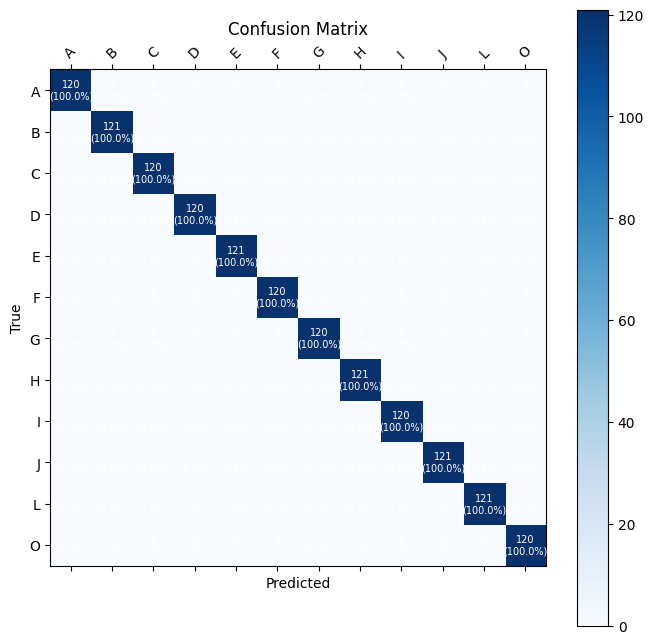

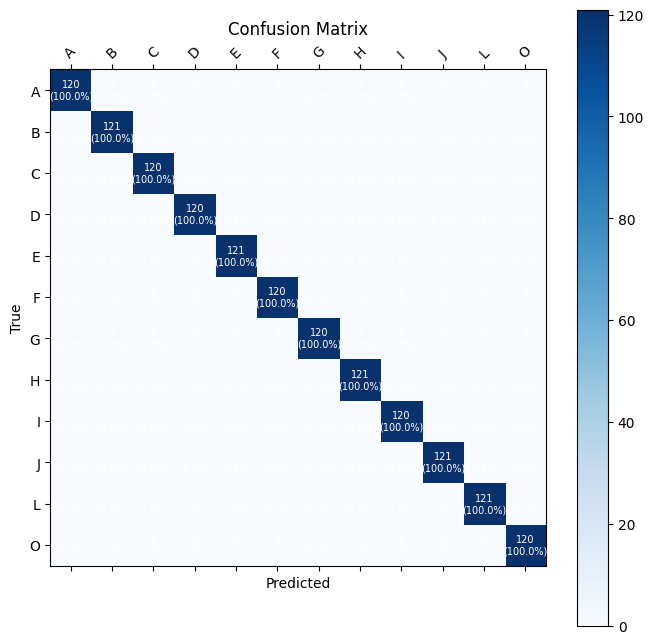

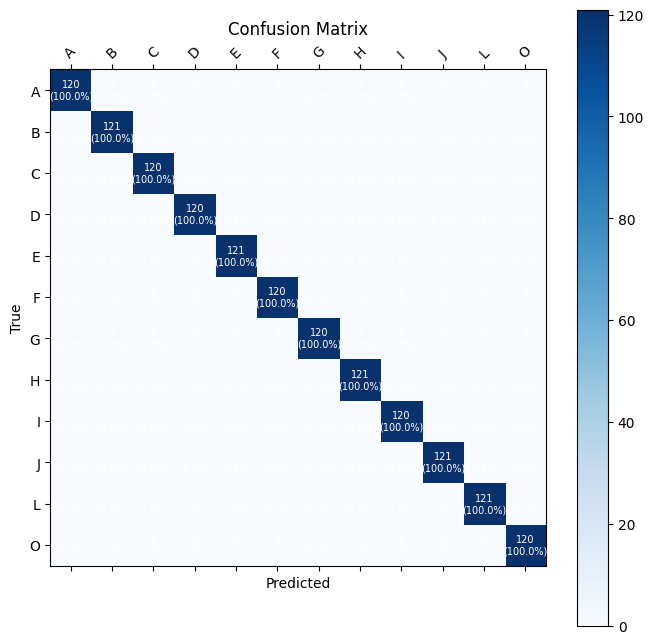

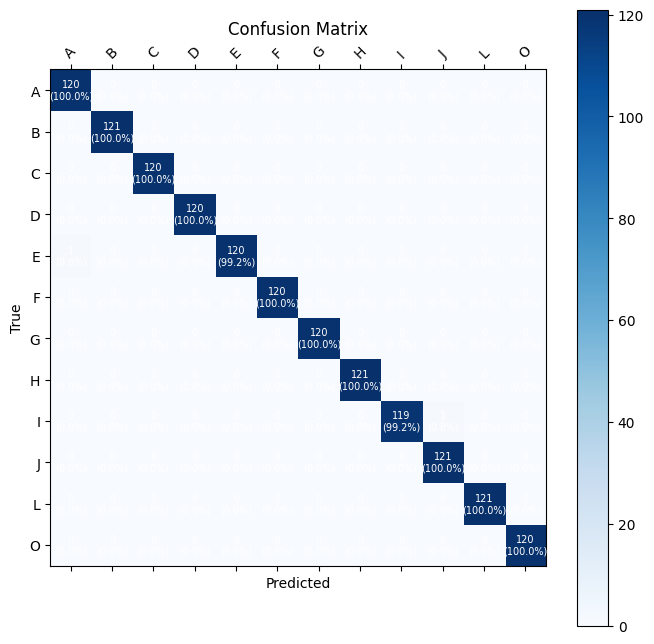

In [19]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[3], np.unique(y_test))

In [20]:
def add_features(X, y, subset_freqs, HG_diff=True, LG_diff=True):

    X['Sample'] = y

    # Initialize a dictionary to store results
    mean_std_dict = {}

    for freq in subset_freqs:
        # Calculate HG and LG mean values for each frequency
        agg_dict = {}
        if f'{freq}.0 LG (mV) mean' in X.columns:
            agg_dict['LG_mean'] = (f'{freq}.0 LG (mV) mean', 'mean')
        if f'{freq}.0 HG (mV) mean' in X.columns:
            agg_dict['HG_mean'] = (f'{freq}.0 HG (mV) mean', 'mean')
        
        mean_std_dict[freq] = X.groupby('Sample').agg(**agg_dict).reset_index()

        mean_std_dict[freq]['Frequency'] = freq

    # Concatenate all DataFrames in the dictionary
    mean_std_df = pd.concat(mean_std_dict.values(), ignore_index=True)

    # For each frequency after first one
    for i, freq in enumerate(subset_freqs[1:]):
        prev_freq = subset_freqs[i]  # Get previous frequency
        
        # For each row
        for idx, row in X.iterrows():
            sample = row['Sample']
            
            if HG_diff:
                # Get previous frequency's HG mean for this sample
                prev_hg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['HG_mean'].values[0]


                # 1) Inputs: xt - (xt-1) --First-order differences
                # 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

                # Calculate and store difference
                X.loc[idx, f'{freq}.0 HG diff'] = X.loc[idx, f'{freq}.0 HG (mV) mean'] - prev_hg
                # X.loc[idx, f'{freq}.0 HG relative diff'] = (X.loc[idx, f'{freq}.0 HG (mV) mean'] / prev_hg) -1


            if LG_diff:
                prev_lg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['LG_mean'].values[0]

                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 LG diff'] = X.loc[idx, f'{freq}.0 LG (mV) mean'] - prev_lg
                X.loc[idx, f'{freq}.0 LG relative diff'] = (X.loc[idx, f'{freq}.0 LG (mV) mean'] / prev_lg) -1


    # Drop the 'Sample' column
    X = X.drop(columns=['Sample'])

    return X
  

### Load New Test Data
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [42]:
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/processed/new_sample/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 1
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")
# print(f"X_shape: {X_train.shape}")

# load the label encoder
le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -1.098767  45.659870      A
1            100.0 -0.854596  32.718837      A
2            100.0 -1.220852  22.829935      A
3            100.0  0.610426  37.846416      A
4            100.0 -0.488341  20.266145      A
5            100.0 -0.244170  22.463679      A
6            100.0 -0.732511  24.539128      A
7            100.0 -1.465023  28.934196      A
8            100.0 -0.488341  25.882065      A
9            100.0  1.098767  46.026126      A
Data percentage: 0.5555555555555556%
Data percentage test: 1.666666666666667%
New sample shape: (2185, 201)


## Define training and testing data

In [43]:
labels = ['B', 'C', 'E', 'R']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']


# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

# Favourite frequencies
freqs_fav = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
# freqs_fav = [340,360,370,380,390,400,410,420]
# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
freqs = [
        [250, 300, 320],
        [330, 340, 350],
        [360, 370, 380],
        [390, 400, 410],
        [420, 430, 440],
        [450, 460, 470],
        [480, 490, 500],
        [510, 520, 530, 540]
    ]

freqs.append(freqs_fav)

# Add all frequencies one by one
for i in range(250, 591, 10):
    freqs.append([i])

# Add groups of 2 frequencies
for i in range(240, 591, 20):
    if i + 10 <= 590:
        freqs.append([i, i+10])

# Add groups of 3 frequencies
for i in range(250, 591, 30):
    if i + 20 <= 590 and i + 10 <= 590:
        freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
freqs.append(list(range(100, 591, 10)))

freqs.append([250,320,330,410])

# freqs = freqs_fav ## TESTING

print(freqs)

[[250, 300, 320], [330, 340, 350], [360, 370, 380], [390, 400, 410], [420, 430, 440], [450, 460, 470], [480, 490, 500], [510, 520, 530, 540], [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540], [250], [260], [270], [280], [290], [300], [310], [320], [330], [340], [350], [360], [370], [380], [390], [400], [410], [420], [430], [440], [450], [460], [470], [480], [490], [500], [510], [520], [530], [540], [550], [560], [570], [580], [590], [240, 250], [260, 270], [280, 290], [300, 310], [320, 330], [340, 350], [360, 370], [380, 390], [400, 410], [420, 430], [440, 450], [460, 470], [480, 490], [500, 510], [520, 530], [540, 550], [560, 570], [580, 590], [250, 260, 270], [280, 290, 300], [310, 320, 330], [340, 350, 360], [370, 380, 390], [400, 410, 420], [430, 440, 450], [460, 470, 480], [490, 500, 510], [520, 530, 540], [550, 560, 570], [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 26

In [44]:
def inference_sampling(predictions):
    """
    Takes a list of predictions and returns the most common value
    Args: predictions: List of prediction values
    Returns: Most frequent prediction value
    """
    if not predictions:
        return None
        
    # Count frequency of each prediction
    freq_dict = {}
    for pred in predictions:
        freq_dict[pred] = freq_dict.get(pred, 0) + 1
    
    # Find value with highest frequency
    max_freq = 0
    mode = None
    for value, freq in freq_dict.items():
        if freq > max_freq:
            max_freq = freq
            mode = value
            
    return mode

### Use probabilities with inference_sampling? threshold?

In [45]:
def predict_with_probabilities(model, X):
    """
    Perform inference on the dataset using the trained model and return predictions with probabilities.

    Parameters:
    model: Trained model object with predict and predict_proba methods.
    X: Dataset to perform inference on.

    Returns:
    predictions: Array of predicted class labels.
    probabilities: Array of predicted probabilities for each class.
    """
    # Predict class labels
    predictions = model.predict(X)
    
    # Predict probabilities
    probabilities = model.predict_proba(X)
    
    return predictions, probabilities

In [25]:
def evaluate_models_with_sampling(models, X, y_true):
    """
    Evaluate multiple models using inference sampling
    
    Args:
        models: List of trained model objects
        X: Features dataset
        y_true: True labels
        
    Returns:
        Dictionary with evaluation metrics
    """
        
    # Get predictions from each model
    all_predictions = []
    for model in models:
        preds, _ = predict_with_probabilities(model, X)
        all_predictions.append(preds)
    
    # Get final predictions using sampling
    final_predictions = []
    for i in range(len(X)):
        sample_preds = [pred[i] for pred in all_predictions]
        final_pred = inference_sampling(sample_preds)
        final_predictions.append(final_pred)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, final_predictions),
        'precision': precision_score(y_true, final_predictions, average='weighted'),
        'recall': recall_score(y_true, final_predictions, average='weighted'),
        'f1': f1_score(y_true, final_predictions, average='weighted')
    }
    
    return metrics

## Notes
- 01. 0.32159
- 02. 0.29434 - Removing LG barely affects the results, in some cases even improve the results.
- 03. 0.32377 - Without std deviation good results are obtained in different frequencies than the original model.
- 04. 0.31058 - Results with relative scaling are not considerably better in general. With 1 frequency results are the same as with one frequency only since the data is the same
- 05. 0.31136 - Results with first order difference are not considerably better in general. With 1 frequency results are the same as with one frequency only since the data is the same. It is slightly better in RF models.


## Testing

In [46]:
csv_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/exp_5/06_testing_results_12p.csv'

# Training options
drop_sample = True
eliminate_std_dev = False
eliminate_LG = False
HG_diff = False
LG_diff = False
apply_pca = True

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    if apply_pca:
        pca = PCA(n_components=0.95)  # Adjust n_components as needed
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB']

    # Train the models
    rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

    # Make Predictions
    y_pred = [
        rf_model.predict(X_test),
        nb_model.predict(X_test),
        lr_model.predict(X_test),
        gb_model.predict(X_test)
    ]
        
    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='test',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )

    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_new_sample = add_features(X_new_sample, y_new_sample, subset_freqs, HG_diff, LG_diff)

    if apply_pca:
        X_new_sample = pca.transform(X_new_sample)

    # Make Predictions
    y_pred_ns = [
        rf_model.predict(X_new_sample),
        nb_model.predict(X_new_sample),
        lr_model.predict(X_new_sample),
        gb_model.predict(X_new_sample)
    ]

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='new_sample',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )


Frequency: [250, 300, 320]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9502418797512094
Model 2 - Accuracy: 0.9101589495507948
Model 3 - Accuracy: 0.874913614374568
Model 4 - Accuracy: 0.9250172771250864


PermissionError: [Errno 13] Permission denied: 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/exp_5/06_testing_results_12p.csv'

### Principal Component Analysis

In [44]:
# Apply PCA
n_components = 5
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

le = joblib.load('label_encoder.pkl')

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

def plot_pca_visualization(X_train_pca, y_pca):

    # Encode labels and get unique class count
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_pca)
    n_classes = len(np.unique(y_encoded))
    
    # Create custom colormap
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    colors = colors[:n_classes]
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    
    # Plot
    plt.figure(figsize=(12, 9))
    scatter = plt.scatter(X_train_pca[:, 0], 
                         X_train_pca[:, 1],
                         c=y_encoded,
                         cmap=custom_cmap,
                         edgecolor='k', 
                         s=25)
    
    # Custom legend
    legend_elements = [plt.Line2D([0], [0], 
                                marker='o', 
                                color='w',
                                markerfacecolor=colors[i], 
                                label=class_name,
                                markersize=10) 
                      for i, class_name in enumerate(le.classes_)]
    
    plt.legend(handles=legend_elements, title="Classes")
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Visualization of Classes')
    plt.show()
    
    return le

plot_pca_visualization(X_train_pca, y_pca)

def show_pca_components(pca, X_train, n_components=5, n=10):
    # Create a DataFrame with the PCA components
    components = pd.DataFrame(pca.components_, columns=X_train.columns)
    # Transpose the DataFrame
    components = components.T
    # Display the highest and lowest n variables of the first n_components
    for i in range(n_components):
        print(f"Component {i+1}:")
        print(components[i].nlargest(n), '\n')
        print(components[i].nsmallest(n), '\n')

# show_pca_components(pca, X_train, n_components)

## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

def plot_data_visualization(X_train, y_train, var1, var2):
    
    # Get unique classes and encode
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_train)
    n_classes = len(np.unique(y_encoded))
    
    # Create custom colormap with only needed colors
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Get all 20 colors
    colors = colors[:n_classes]  # Take only needed colors
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    
    # Create plot
    plt.figure(figsize=(12, 9))
    scatter = plt.scatter(X_train[var1], 
                         X_train[var2],
                         c=y_encoded,
                         cmap=custom_cmap,
                         edgecolor='k', 
                         s=25)
    
    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], 
                                marker='o', 
                                color='w',
                                markerfacecolor=colors[i], 
                                label=class_name,
                                markersize=10) 
                      for i, class_name in enumerate(le.classes_)]
    
    plt.legend(handles=legend_elements, title="Classes")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

plot_data_visualization(X_train, y_train, var1, var2)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>